In [8]:
import matplotlib.pyplot as plt
import numpy as np

from vessel_models import VesselModel
from controller import MPC, MHE

In [9]:
# Global simulation variables (used by both MPC and MHE)
N = 100
dt = 0.1
ns = 6
nu = 3

# MHE simulation variables
nc = 13 + 6 # hydrodynamic coefficients + 6 tweak factors
N_mhe = 10

# MPC simulation variables
N_mpc = 10 # default 10
N_sim = N + N_mpc

# Cost matrices
Qvec = 3*np.ones(ns)
Rvec = np.ones(nu)
Qfvec = 10*np.ones(ns)
Pvec = 0.3*np.ones(nc)

# Reference trajectory and inputs
Sload = np.loadtxt('dircol_soln.csv', delimiter=',')
Uload = np.loadtxt('dircol_inpu.csv', delimiter=',')

# MPC reference trajectory augmentation
Sf = Sload[-1]
Sref = np.tile(Sf, (N_sim, 1))
Sref[:N] = Sload

# Obstacle States
num_obstacles = 2
obstacles = np.zeros((num_obstacles,3))
obstacles[0] = [0.25, 0.25, 0.1]
obstacles[1] = [0.75, 0.75, 0.1]

# Vessel Models
model = VesselModel()
model_unc = VesselModel(mismatch=True)

{'X_u': -0.692237684818467, 'X_uu': -1.6988430388667242, 'Y_v': -1.2636647037301665, 'Y_vv': -68.28094900175819, 'Y_r': 1.1537849537047284, 'N_v': 0.3268521115390127, 'N_r': -0.2949103638527607, 'N_rr': -1.266559929067009, 'X_du': -3.3070526259796003, 'Y_dv': -14.933518880111757, 'Y_dr': 0.24007988402867675, 'N_dv': 0.6597442957938815, 'N_dr': -0.7686894571459812, 'm': 40.402244611546855, 'I_z': 3.665064168829452, 'x_g': 0.14474919087411536}


In [10]:
U_soln = np.zeros((N-1, nu))
S_soln = np.zeros((N, ns))
S_soln[0] = Sref[0]
C_soln = np.zeros((N-1, nc))

MHE_coeff_test = np.zeros(nc)
MHE_coeff_test[:13] = [-0.7225, -1.3274, -0.8612, -36.2823, 0.1079, 0.1052, -0.5,
                       -1.0, -2.0, -10.0, 0.0, 0.0, -1.0]

mhe_traj_init = np.zeros((N_mhe, ns))
mhe_traj_init[0] = [0, 0, np.pi/4, 0, 0, 0]
mhe_inpu_init = np.tile([10, 0, 2], (N_mhe-1, 1))
mhe_C_init = np.zeros((1, nc))

for i in range(N_mhe-1):
    Sn = mhe_traj_init[i]
    Un = mhe_inpu_init[i]
    mhe_traj_init[i+1] = model.rk4(Sn, Un, dt)

mhe_optimizer = MHE(model, N_mpc, ns, nu, nc, dt, Qvec, Rvec, Qfvec, Pvec,
                mhe_C_init, mhe_traj_init, mhe_inpu_init)
mhe_optimizer.exec_MPC()
mhe_C_init = mhe_optimizer.sol.x
C_soln[0] = mhe_C_init

for i in range(N-1):
    s0 = S_soln[i]
    sf = Sref[i+N_mpc-1] # use for solving following a trajectory
    sref = Sref[i:i+N_mpc]
    trajoptimizer = MPC(model, N_mpc, ns, nu, dt, Qvec, Rvec, Qfvec, s0, sf, sref, obstacles)
    
    if i >= N_mhe:
        sref_mhe = S_soln[i-N_mhe:i]
        uref_mhe = U_soln[i-N_mhe:i-1]
        c0 = C_soln[i-N_mpc]
        mhe_optimizer = MHE(model, N_mpc, ns, nu, nc, dt, Qvec, Rvec, Qfvec, Pvec, c0, sref_mhe, uref_mhe)
        mhe_optimizer.exec_MPC()
        mhe_coeff = mhe_optimizer.sol.x
        C_soln[i-N_mpc+1] = mhe_coeff

        trajoptimizer.exec_MPC(version="with_MHE", MHE_coeff=mhe_coeff)

    else:
        trajoptimizer.exec_MPC(version="with_MHE", MHE_coeff=mhe_C_init)

    S, U = trajoptimizer.flat2vec(trajoptimizer.sol.x)
    U_soln[i] = U[0]
    #S_soln[i+1] = model.rk4(s0, U[0], dt)
    S_soln[i+1] = model.rk4_addvel(s0, U[0], dt)

This is Ipopt version 3.14.17, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      722
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       19
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       38
        inequality constraints with only lower bounds:       38
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2452780e+00 0.00e+00 2.86e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
   

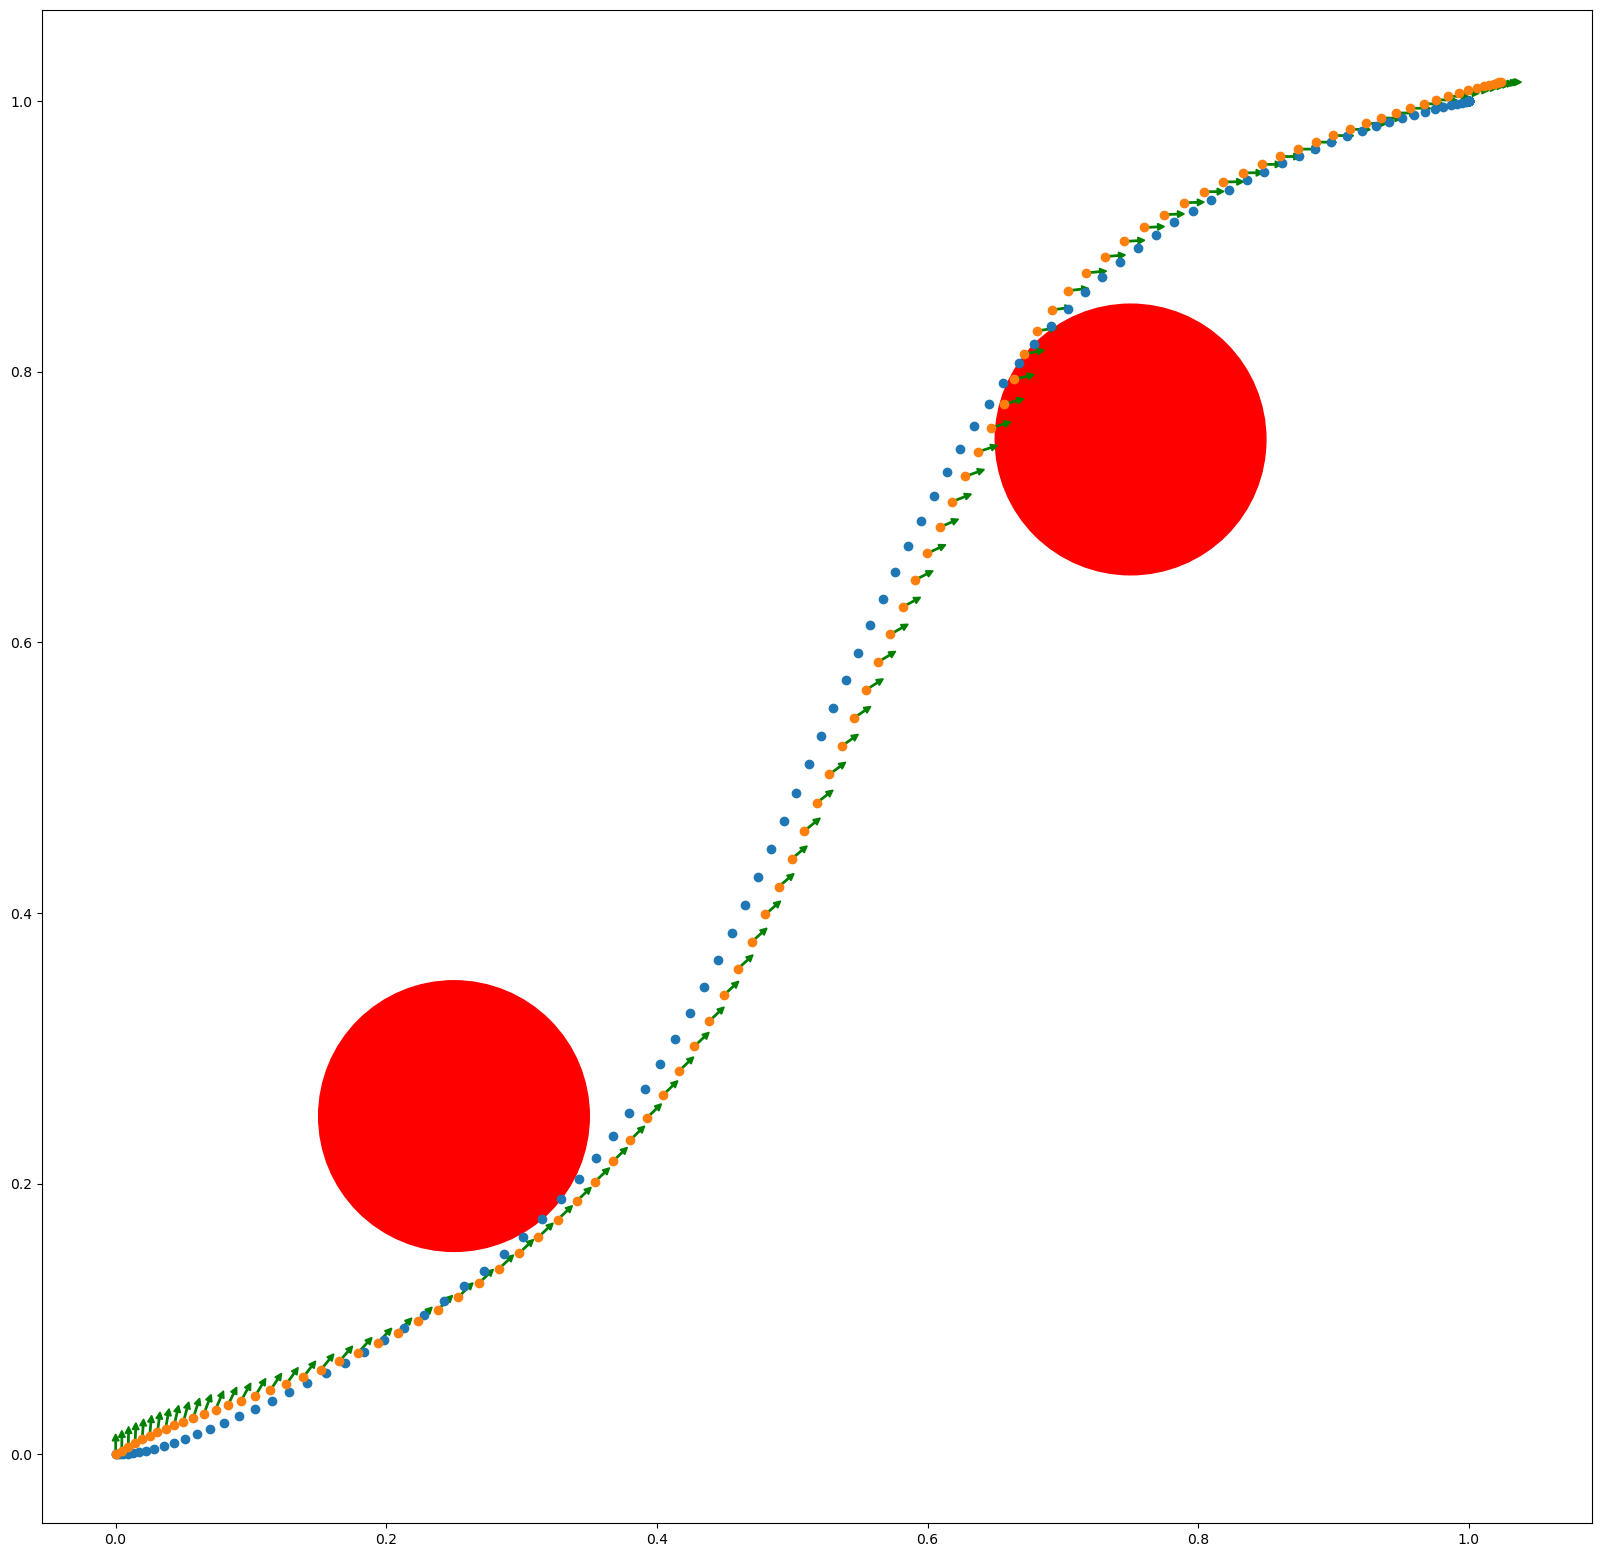

In [11]:
ps = S_soln.T
ps_ref = Sref.T
fig, axes = plt.subplots(1, 1, figsize=(20, 20))

for obstacle in obstacles:
    obs_x, obs_y, obs_r = obstacle
    circle = plt.Circle((obs_y, obs_x), obs_r, color='r')
    axes.add_patch(circle)

for i in range(len(ps[1])):
    dx = 0.01*np.cos(ps[2,i])
    dy = 0.01*np.sin(ps[2,i])
    axes.arrow(ps[1,i], ps[0, i], dy, dx, head_width=0.005, head_length=0.005, fc='green', ec='green')
    
axes.scatter(ps_ref[1], ps_ref[0])
axes.scatter(ps[1], ps[0])
axes.set_aspect('equal', adjustable='box')
plt.show()